In [1]:
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chaitanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Chaitanya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import os
import re
import json
import emoji
import pandas as pd
import googleapiclient.discovery

In [3]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus.reader.tagged import word_tokenize
nltk.download('stopwords')
stopwordsList = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chaitanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Samsung Galaxy Flip 5
video_id="MeuycYr8qEo"
next_page_token=""
commentsList=[]

# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "[INSERT KEY]"

youtube = googleapiclient.discovery.build(
  api_service_name, api_version, developerKey = DEVELOPER_KEY)

In [5]:
def send_request():
  request = youtube.commentThreads().list(
    part="id,snippet",
    order="relevance",
    maxResults=100,
    videoId=video_id,
    pageToken=next_page_token
  )
  response = request.execute()
  resp=json.loads(json.dumps(response))
  return resp

In [6]:
def process_response(resp):
  global next_page_token
  for items in resp['items']:
    topLevelComment=items['snippet']['topLevelComment']
    commentMetadata=[None]*4
    commentMetadata[0]=topLevelComment['id']
    snippet=topLevelComment['snippet']
    commentMetadata[1]=snippet['authorDisplayName']
    commentMetadata[2]=snippet['textOriginal']
    commentMetadata[3]=int(snippet['likeCount'])
    commentsList.append(commentMetadata)
  if 'nextPageToken' in resp:
    next_page_token=resp['nextPageToken']
  else:
    next_page_token=""

In [7]:
def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.distinct_emoji_list(s))

In [8]:
def remove_escape_chars(s):
  for c in '\b\n\r\t\\':
    s = s.replace(c, ' ')
  return s

In [9]:
def remove_special_chars(s):
  return re.sub('[^a-zA-Z ]', ' ', s)

In [10]:
while len(commentsList)<=1000:
  resp = send_request()
  process_response(resp)
  if next_page_token=="":
    break

In [11]:
df=pd.DataFrame(commentsList,columns=['id','author','comment','likes'])
df.insert(3, 'emoji', '')
df['emoji'] = df.comment.apply(extract_emojis)
df['comment']=df.comment.apply(remove_escape_chars).apply(remove_special_chars).str.lower().str.strip()

In [12]:
df.drop_duplicates("comment", inplace=True)
df.head()

,id,author,comment,emoji,likes
0,UgyiHQUU7aqs0IYolSx4AaABAg,Samsung,join us on the flip side and tell us how much ...,😍,49
1,UgxPAxDQRdjOUxrLlsZ4AaABAg,Abir,you are making my childhood dreams come true ...,,52
2,UgxhuPYLu0u7CA-fFrh4AaABAg,Александър Павлов,i can t believe the video was partly filmed in...,,121
3,Ugxj2ZtOZ8jcrLOgOaN4AaABAg,Tian Pregelj,the screen x the size is crazy,,60
4,UgysCwS2aPU2kL_LKCh4AaABAg,Nof4c3,i really hope they bring back inches phones ...,,24


In [13]:
sid = SentimentIntensityAnalyzer()
print(df.loc[1]['comment'])
sid.polarity_scores(df.loc[1]['comment'])

you are making my childhood dreams come true  thank you  samsung


{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.7906}

In [14]:
df["scores"] = df["comment"].apply(lambda x: sid.polarity_scores(x))
df.head()

,id,author,comment,emoji,likes,scores
0,UgyiHQUU7aqs0IYolSx4AaABAg,Samsung,join us on the flip side and tell us how much ...,😍,49,"{'neg': 0.0, 'neu': 0.792, 'pos': 0.208, 'comp..."
1,UgxPAxDQRdjOUxrLlsZ4AaABAg,Abir,you are making my childhood dreams come true ...,,52,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound..."
2,UgxhuPYLu0u7CA-fFrh4AaABAg,Александър Павлов,i can t believe the video was partly filmed in...,,121,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Ugxj2ZtOZ8jcrLOgOaN4AaABAg,Tian Pregelj,the screen x the size is crazy,,60,"{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp..."
4,UgysCwS2aPU2kL_LKCh4AaABAg,Nof4c3,i really hope they bring back inches phones ...,,24,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp..."


In [15]:
df["scores"] = df["scores"].apply(lambda x: x["compound"])
df.head()

,id,author,comment,emoji,likes,scores
0,UgyiHQUU7aqs0IYolSx4AaABAg,Samsung,join us on the flip side and tell us how much ...,😍,49,0.6705
1,UgxPAxDQRdjOUxrLlsZ4AaABAg,Abir,you are making my childhood dreams come true ...,,52,0.7906
2,UgxhuPYLu0u7CA-fFrh4AaABAg,Александър Павлов,i can t believe the video was partly filmed in...,,121,0.0000
3,Ugxj2ZtOZ8jcrLOgOaN4AaABAg,Tian Pregelj,the screen x the size is crazy,,60,-0.3400
4,UgysCwS2aPU2kL_LKCh4AaABAg,Nof4c3,i really hope they bring back inches phones ...,,24,0.4927


In [16]:
sentiment_scores = {}
sentiment_scores["positive"] = df.loc[df["scores"]>=0.3,["likes"]].agg(['sum', 'count']).sum()[0]
sentiment_scores["neutral"] = df.loc[(df["scores"]<0.3) & (df["scores"]>-0.3),["likes"]].agg(['sum', 'count']).sum()[0]
sentiment_scores["negative"] = df.loc[df["scores"]<=-0.3,["likes"]].agg(['sum', 'count']).sum()[0]

In [17]:
sentiment_scores

{'positive': 254, 'neutral': 300, 'negative': 79}

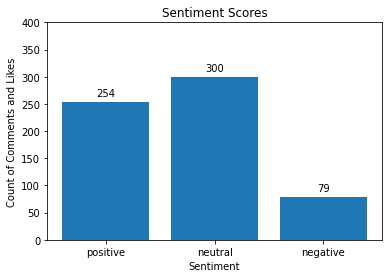

In [18]:
import matplotlib.pyplot as plt
plt.bar(list(sentiment_scores.keys()),list(sentiment_scores.values()))
plt.xlabel("Sentiment")
plt.ylabel("Count of Comments and Likes")
plt.ylim(0,400)
for item in sentiment_scores:
    plt.text(item,sentiment_scores[item]+10,sentiment_scores[item], ha="center")
plt.title("Sentiment Scores")
plt.show()

In [19]:
def removeStopWords(text):
    cleanText=[]
    for w in text:
        if w not in stopwordsList:
            cleanText.append(w)
    return cleanText

In [20]:
def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele + " "
    return str1

In [21]:
df['tokens'] = df['comment'].apply(lambda x: word_tokenize(x))
df['tokens'] = df['tokens'].apply(lambda x: removeStopWords(x))
df['tokens'] = df['tokens'].apply(lambda x: listToString(x))
df

,id,author,comment,emoji,likes,scores,tokens
0,UgyiHQUU7aqs0IYolSx4AaABAg,Samsung,join us on the flip side and tell us how much ...,😍,49,0.6705,join us flip side tell us much fun flexing htt...
1,UgxPAxDQRdjOUxrLlsZ4AaABAg,Abir,you are making my childhood dreams come true ...,,52,0.7906,making childhood dreams come true thank samsung
2,UgxhuPYLu0u7CA-fFrh4AaABAg,Александър Павлов,i can t believe the video was partly filmed in...,,121,0.0000,believe video partly filmed bulgaria especiall...
3,Ugxj2ZtOZ8jcrLOgOaN4AaABAg,Tian Pregelj,the screen x the size is crazy,,60,-0.3400,screen x size crazy
4,UgysCwS2aPU2kL_LKCh4AaABAg,Nof4c3,i really hope they bring back inches phones ...,,24,0.4927,really hope bring back inches phones even inch...
...,...,...,...,...,...,...,...
150,UgzYSCA5wcszlVkyERJ4AaABAg,Ant Ven,proably doesnt have sd slot no thanks,,0,0.1779,proably doesnt sd slot thanks
152,Ugy9LnfZYK5-PTSBGiB4AaABAg,Jesus Morales,i got the flip months ago,🥲,0,0.0000,got flip months ago
153,UgxRPkqerE5LywaFNGR4AaABAg,Mohamed Humaam,lol,,0,0.4215,lol
154,UgzByfl3ovqXoxmUMVd4AaABAg,SATYAM YADAV,ad girl name,,1,0.0000,ad girl name


In [22]:
from wordcloud import WordCloud

In [23]:
negative_comments = ' '.join(df[df['scores']<=-0.3]["tokens"])

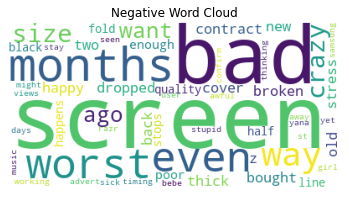

In [24]:
wc_neg = WordCloud(background_color ='white',stopwords = 
                   ["phone","year","flip","last","get","x","though","im","ugh","ive","month","years","using","rd",
                   "ever","across","one","road","yes"]
                   ,min_font_size = 10).generate(negative_comments)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Negative Word Cloud")
plt.show()

In [25]:
positive_comments = ' '.join(df[df['scores']>=0.3]["tokens"])

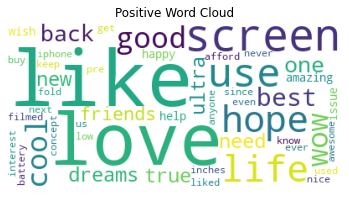

In [26]:
wc_neg = WordCloud(background_color ='white',stopwords = 
                   ["samsung","phone","flip","got","come","much","instead","year","tell","please","phones",
                   "galaxy","really","ad","N","sure","plus","years","go","miracle","doesnt","z"]
                   ,min_font_size = 10).generate(positive_comments)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Positive Word Cloud")
plt.show()